# Module 4 - G-Eval - using LLMs for assessing text quality

In this notebook, we present an example of using large language models to assess the quality of automatically generated text. For this, we will replicate part of the experiments performed by [G-eval](https://arxiv.org/abs/2303.16634)'s authors and compare our results rather those reported in the paper.

To do so, we will apply a pipeline that comprises the following steps:
1. Downloading and loading the [SummEval dataset](https://direct.mit.edu/tacl/article/doi/10.1162/tacl_a_00373/100686/SummEval-Re-evaluating-Summarization-Evaluation).
2. Preparing the data.
3. Using GPT-4 (or gpt-3.5-turbo) for generating the scores.
4. Computing the correlations of the G-eval values with the human annotations from SummEval.

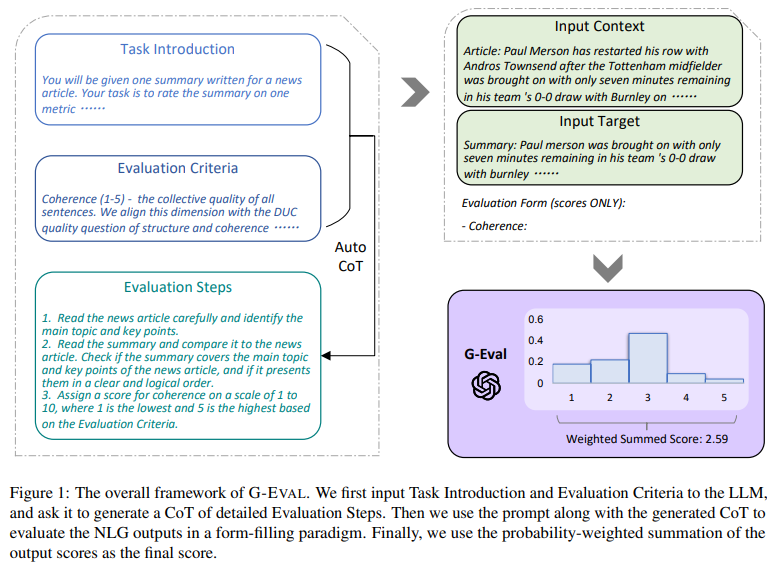

# Installing required packages

In this example, we have to install two libraries:

**`datasets`**:

Datasets is another open-source library developed by Hugging Face that provides a collection of preprocessed datasets for various NLP tasks, such as sentiment analysis, natural language inference, machine translation, and many more. The library provides a unified API to access these datasets, making it easy to load, process, and analyze them.

**`openai`**:

OpenAI is an artificial intelligence research laboratory consisting of the for-profit corporation OpenAI LP and its parent company, the non-profit OpenAI Inc. The OpenAI library is a powerful machine learning library that provides an easy-to-use interface to the OpenAI API. With this library, users can easily integrate OpenAI's state-of-the-art language models, including GPT-3, into their applications, and leverage the full power of these models to perform various natural language processing (NLP) tasks, such as language generation, classification, question-answering, and more.


In [11]:
!pip install datasets
!pip install openai

In addition, we will clone the G-eval repository from GitHub in this environment, which allows us to use the G-eval prompts.

In [12]:
!git clone https://github.com/nlpyang/geval.git

fatal: destination path 'geval' already exists and is not an empty directory.


# Downloading Data

## Download CNN/DM dataset

To demonstrate the use of the GPTScore in text summarization, we will download the CNN/Daily Mail dataset. The CNN/Daily Mail is a popular dataset used for text summarization tasks. To download the dataset, we will make use of the **`load_dataset`** function from the Hugging Face's **`datasets`** library. The following code downloads the dataset and loads the version 1.0.0 of the dataset into the **`dataset`** variable:


In [13]:
from datasets import load_dataset

data_files = {"train": "train.csv", "test": "test.csv"}
dataset = load_dataset('cnn_dailymail', '1.0.0')

The below code is using the **`pandas`** library to create a DataFrame from the **`test`** split of the CNN/Daily Mail dataset.

The DataFrame is a two-dimensional table where each column can have a different data type. In this case, each row of the DataFrame represents a document and the columns represent metadata associated with the document. The DataFrame will allow us to manipulate and analyze the dataset in a more convenient way, such as filtering or sorting by metadata columns, or merging with other DataFrames. The **`pd.DataFrame`** function takes a dictionary-like object (in this case, **`dataset['test']`**) as input and returns a DataFrame.

In [14]:
import pandas as pd

df = pd.DataFrame(dataset['test'])

## Download SummEval annotations

The next step in this process is to download the SummEval annotations, which contain human evaluations of automatically generated summaries of the CNN/DM documents. These annotations will be useful to evaluate the quality of the summaries produced by the models that we will use.

Check SummEval [paper](https://direct.mit.edu/tacl/article/doi/10.1162/tacl_a_00373/100686) for more details.

In [15]:
!wget https://storage.googleapis.com/sfr-summarization-repo-research/model_annotations.aligned.jsonl

--2024-06-04 10:06:49--  https://storage.googleapis.com/sfr-summarization-repo-research/model_annotations.aligned.jsonl
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.207, 172.253.62.207, 172.253.115.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5839062 (5.6M) [application/octet-stream]
Saving to: ‘model_annotations.aligned.jsonl’

model_annotations.a 100%[===================>]   5.57M  --.-KB/s    in 0.04s   

2024-06-04 10:06:50 (145 MB/s) - ‘model_annotations.aligned.jsonl’ saved [5839062/5839062]



In the next cell, we load the SummEval annotations to a list of dictionaries.

In [16]:
import json
f = open("model_annotations.aligned.jsonl","r")
data = [json.loads(l) for l in f.readlines()]

# Preparing Data

## Extract data and construct prompts

Summeval summaries were evaluated by humans considering 4 criteria: **relevance**, **fluency**, **consistency**, and **coherence**. In this notebook, we will replicate the G-eval experiments only considering the **consistency** criterion.

Let's load the prompt template for the consistency criterion and see how it looks like.

In [17]:
prompt = open("geval/prompts/summeval/con_detailed.txt","r").read()

print(prompt)

You will be given a news article. You will then be given one summary written for this article.

Your task is to rate the summary on one metric.

Please make sure you read and understand these instructions carefully. Please keep this document open while reviewing, and refer to it as needed.


Evaluation Criteria:

Consistency (1-5) - the factual alignment between the summary and the summarized source. A factually consistent summary contains only statements that are entailed by the source document. Annotators were also asked to penalize summaries that contained hallucinated facts. 

Evaluation Steps:

1. Read the news article carefully and identify the main facts and details it presents.
2. Read the summary and compare it to the article. Check if the summary contains any factual errors that are not supported by the article.
3. Assign a score for consistency based on the Evaluation Criteria.


Example:


Source Text: 

{{Document}}

Summary: 

{{Summary}}


Evaluation Form (scores ONLY):


Now, let's format the prompt with the source document and target summary. We just have to replace `{{Document}}` with the source document and `{{Summary}}` with the target summary.

In [18]:
# extracting source documents
scrs = [df[df["id"]==item['id'].split("-")[-1]]["article"].item() for item in data]
# extracting target summaries
tgts = [item["decoded"] for item in data]
# Formatting the prompt
prompts = [prompt.replace("{{Document}}", scr).replace("{{Summary}}", tgt) for scr, tgt in zip(scrs, tgts)]

Let's check an example

In [19]:
print(prompts[0])

You will be given a news article. You will then be given one summary written for this article.

Your task is to rate the summary on one metric.

Please make sure you read and understand these instructions carefully. Please keep this document open while reviewing, and refer to it as needed.


Evaluation Criteria:

Consistency (1-5) - the factual alignment between the summary and the summarized source. A factually consistent summary contains only statements that are entailed by the source document. Annotators were also asked to penalize summaries that contained hallucinated facts. 

Evaluation Steps:

1. Read the news article carefully and identify the main facts and details it presents.
2. Read the summary and compare it to the article. Check if the summary contains any factual errors that are not supported by the article.
3. Assign a score for consistency based on the Evaluation Criteria.


Example:


Source Text: 

Paul Merson has restarted his row with Andros Townsend after the Totte

## Extracting annotations from SummEval.

In SummEval, annotators were asked to rate summaries considering four different aspects:

1. **Consistency**: the factual alignment between the summary and the summarized source.
2. **Coherence**: the collective quality of all sentence.
3. **Relevance**: selection of important content from the source.
4. **Fluency**: the quality of individual sentences.

Three expert annotators participated in the research (`expert_annotations`). Five crowd-sourced annotators were hired through the Amazon Mechanical Turk platform (`turker_annotations`).

We will test the **consistency**, but you can change this notebook to see how it works regarding the other aspects.

In [20]:
import pandas as pd

aspect = "consistency" # @param ["consistency","coherence","fluency","relevance"]

rates = []
for item in data:
  r = {}
  for i, ex in enumerate(item['expert_annotations']):
    r["expert_{0}".format(i+1)] = ex[aspect]
  for i, ex in enumerate(item['turker_annotations']):
    r["turker_{0}".format(i+1)] = ex[aspect]
  rates.append(r)
rates_df = pd.DataFrame(rates)
rates_df.head()

,expert_1,expert_2,expert_3,turker_1,turker_2,turker_3,turker_4,turker_5
0,1,1,1,3,3,3,3,3
1,5,5,5,3,3,3,3,3
2,5,5,5,5,4,5,5,2
3,5,5,5,5,5,5,5,5
4,5,5,5,4,4,4,4,4


We calculate the mean value the annotators gave to the same summary.

In [21]:
rates_df["expert_mean"] = rates_df[["expert_1","expert_2","expert_3"]].mean(axis=1)

rates_df["turker_mean"] = rates_df[["turker_1","turker_2","turker_3","turker_4","turker_5"]].mean(axis=1)

rates_df["all_mean"] = rates_df[["turker_1","turker_2","turker_3","turker_4","turker_5","expert_1","expert_2","expert_3"]].mean(axis=1)

# Using GPT-3.5-turbo for generating the scores.

To use OpenAI API, we need to set our API key and import the OpenAI module. In the given code, we have the `OPENAI_KEY` variable which we can set to our OpenAI API key. After that, we can use the `openai.api_key` method to set the API key for our session.
You can use [Google Colab Secrets](https://medium.com/@parthdasawant/how-to-use-secrets-in-google-colab-450c38e3ec75) to store your key.

In [22]:
from google.colab import userdata
OPENAI_KEY = userdata.get('openai_api_key')

The function `generate` takes in a list of messages and generates a response using the OpenAI Chat API. The `model` parameter specifies which model to use for generating the response. In the given code, we have used the `gpt-3.5-turbo` model. However, we can also use `gpt-4`.

The `temperature` parameter controls the randomness of the generated response. A higher temperature value will result in a more random response. The `n` parameter specifies the number of responses to generate. The `n` parameter is important for G-eval, as it allows us to generate multiple scores and take the average of the scores.

In [23]:
import os
from openai import OpenAI
client = OpenAI(api_key=OPENAI_KEY)

temperature = 1.0 # @param
number_of_samples = 20 # @param
model = "gpt-4" # @param

def generate(messages,model=model):
  response = client.chat.completions.create(
    model=model,
    messages=messages,
    temperature=temperature,
    n=number_of_samples
  )
  all_responses = [choice.message.content for choice in response.choices]

  return all_responses



# Scoring

GPT-3.5-turbo can generate text in addition to the score. So, we need to extract the score from the generated text. The score is the last number in the generated text. We can use a regular expression to extract the score from the generated text.

In [24]:
import re
def parse_output(output):
    matched = re.search("^ ?([\d\.]+)", output)
    if (matched):
        try:
            score = float(matched.group(1))
        except:
            score = 0
    else:
        score = 0
    return score

Now, let's define the `scorer` function. The `scorer` function takes in a prompt and returns a score. The `scorer` function generates a response using the `generate` function. Then, it extracts the score from the generated response using the `parse_output` function. Finally, it returns the score.

In [25]:
def scorer(prompt):
  messages = [{"role":"user","content":prompt}]
  responses = generate(messages)
  all_scores = [parse_output(x) for x in responses]
  score = sum(all_scores) / len(all_scores)

  return score

Before running, let's put our prompts in the `rates_df` dataframe. We will use the `prompt` column as the input to the `scorer` function. We will use the `geval` column as the target score. We also select the first 100 rows of the dataframe to speed up the evaluation process.

In [26]:
k_rows = 100 # @param
rates_df["prompt"] = prompts
rates_df = rates_df.head(k_rows)

Now, let's run the `scorer` function on the `prompt` column of the `rates_df` dataframe. We will store the results in the `geval` column of the `rates_df` dataframe.

We import `tqdm` to display a progress bar.

In [27]:
from tqdm import tqdm
import time

scores = []

for prompt in tqdm(rates_df["prompt"].values):
  score = scorer(prompt)
  scores.append(score)
  time.sleep(10) # due to the openai rate limit

rates_df["geval"] = scores

100%|██████████| 100/100 [18:04<00:00, 10.85s/it]


# 4. Compute Correlations

The cell below computes the Spearman's rank correlation coefficient between the rates columns of the **`rates_df`** dataframe.

The [Spearman's rank correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) is a statistical measure that measures the strength and direction of association between two variables. In the context of the STS task, it measures the correlation between the predicted similarity scores produced by the model and the human-labeled similarity scores in the test dataset.

The Spearman's rank correlation coefficient ranges from -1 to 1, where a value of 1 indicates a perfect positive correlation, 0 indicates no correlation, and -1 indicates a perfect negative correlation. Therefore, a higher Spearman's rank correlation coefficient value indicates that the model predictions are closer to the human scores, which is a good indicator of model performance.

The Spearman's rank correlation coefficient can be represented using the following equation:

\begin{equation}
r_s = 1 - \frac{6\sum d_i^2}{n(n^2-1)}
\end{equation}

where $r_s$ is the Spearman's rank correlation coefficient, $d_i$ is the difference between the ranks of the corresponding values in the two variables, and $n$ is the number of observations. The number 6 is a constant that is used to normalize the coefficient. It makes the coefficient fall within the range of -1 to +1.


In [28]:
cols = ["expert_mean","turker_mean","all_mean","geval"]
corr = rates_df[cols].corr(method="spearman")
corr.style.background_gradient(cmap='coolwarm')

,expert_mean,turker_mean,all_mean,geval
expert_mean,1.000000,-0.036218,0.390885,0.464078
turker_mean,-0.036218,1.000000,0.846002,0.193039
all_mean,0.390885,0.846002,1.000000,0.445977
geval,0.464078,0.193039,0.445977,1.000000


We also compute the Kendall's rank correlation coefficient, which is another statistical measure that measures the strength and direction of association between two variables. It is similar to the Spearman's rank correlation coefficient, but it is less sensitive to outliers. The Kendall's rank correlation coefficient can be represented using the following equation:

\begin{equation}
\tau = \frac{n_c - n_d}{\frac{1}{2}n(n-1)}
\end{equation}

where $\tau$ is the Kendall's rank correlation coefficient, $n_c$ is the number of concordant pairs, $n_d$ is the number of discordant pairs, and $n$ is the number of observations.

In [29]:
cols = ["expert_mean","turker_mean","all_mean","geval"]
corr = rates_df[cols].corr(method="kendall")
corr.style.background_gradient(cmap='coolwarm')

,expert_mean,turker_mean,all_mean,geval
expert_mean,1.000000,-0.029211,0.324894,0.419771
turker_mean,-0.029211,1.000000,0.803733,0.156184
all_mean,0.324894,0.803733,1.000000,0.360299
geval,0.419771,0.156184,0.360299,1.000000


#5. Compare your results with G-eval

Compare your results with G-Eval 4 **Consistency** column. The results may be different because of the different sample size. However, the results should be similar.

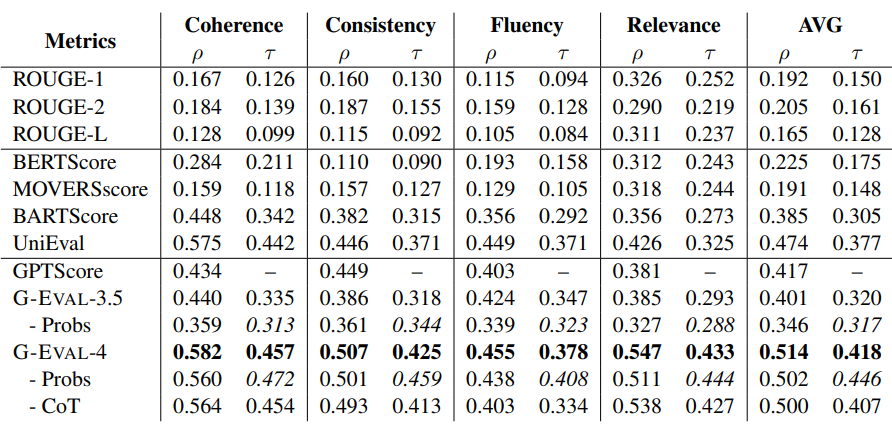